In [1]:
import os 
import wget
import gzip
import math
import matplotlib.pyplot as plt
import random
import scipy
import tensorflow as tf
from collections import defaultdict
from implicit import bpr
from scipy.spatial import distance

/home/zhankui/anaconda3/envs/pml/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data is available at http://cseweb.ucsd.edu/~jmcauley/pml/data/. 
- Download and save to your own directory.
- Or, run following script to save it into `Chapter_10/data` folder automatically.

In [2]:
filenames = [
    'goodreads_reviews_comics_graphic.json.gz',
    'beer.json.gz'
]

dataDir = './data'
url = 'http://jmcauley.ucsd.edu/pml_data'

if not os.path.exists(dataDir):
    os.makedirs(dataDir)
for filename in filenames:
    wget.download(os.path.join(url, filename), out=dataDir)

print("Done!")

Done!


# Basic fairness measurements - interaction and recommendation distributions

Goodreads graphic novel data. Train a standard recommender, and compare generated recommendations to historical interactions, in terms of frequency distributions.

In [3]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [4]:
data = []
for x in parse(os.path.join(dataDir, "goodreads_reviews_comics_graphic.json.gz")):
    del x['review_text']
    data.append(x)

In [5]:
random.shuffle(data)

In [6]:
userIDs,itemIDs = {},{}
revUIDs,revIIDs = {},{}
for d in data:
    u,i = d['user_id'],d['book_id']
    if not u in userIDs:
        userIDs[u] = len(userIDs)
        revUIDs[userIDs[u]] = u
    if not i in itemIDs:
        itemIDs[i] = len(itemIDs)
        revIIDs[itemIDs[i]] = i

In [7]:
nUsers,nItems = len(userIDs),len(itemIDs)
nUsers,nItems

(59347, 89311)

Problem setup follows the BPR library from "implicit" (see Chapter 5), but could be completed with any recommender

In [8]:
Xiu = scipy.sparse.lil_matrix((nItems, nUsers))
for d in data:
    Xiu[itemIDs[d['book_id']],userIDs[d['user_id']]] = 1
    
Xui = scipy.sparse.csr_matrix(Xiu.T)

In [29]:
model = bpr.BayesianPersonalizedRanking(factors = 5, use_gpu = False)

Fit the model

In [30]:
model.fit(Xiu)

100%|██████████| 100/100 [00:02<00:00, 33.62it/s, train_auc=88.90%, skipped=2.41%]


Extract recommendations (example)

In [31]:
model.recommend(0, Xui)

[(6486, 1.889856),
 (1489, 1.7520949),
 (1065, 1.6937006),
 (4062, 1.6836636),
 (41, 1.5747803),
 (10417, 1.5741626),
 (5328, 1.570247),
 (5078, 1.5630256),
 (6350, 1.5610315),
 (3508, 1.5565355)]

Next we extract recommendations for all users, and compare these to their interaction histories. First collect histories from historical trends:

In [32]:
interactionTuples = []
itemsPerUser = defaultdict(list)

In [33]:
for d in data:
    u,i = d['user_id'],d['book_id']
    interactionTuples.append((userIDs[u],itemIDs[i]))
    itemsPerUser[userIDs[u]].append(itemIDs[i])

Next build similar data structures containing recommendations for each user

In [34]:
recommendationTuples = []

For each user, generate a set of recommendations equivalent in size to their number of interactions used for training

In [35]:
for u in range(len(userIDs)):
    A = model.recommend(u, Xui, N = len(itemsPerUser[u]))
    for i, sc in A:
        recommendationTuples.append((u,i))

So far our data structures just contain lists of historical interactions and recommendations for each user. Convert these into counts for each item. This is done both for interactions (I) and recommendations (R).

In [36]:
countsPerItemI = defaultdict(int)
countsPerItemR = defaultdict(int)
for u,i in interactionTuples:
    countsPerItemI[i] += 1

for u,i in recommendationTuples:
    countsPerItemR[i] += 1

Sort counts by popularity to generate plots

In [37]:
sortPopularI = [(countsPerItemI[i], i) for i in countsPerItemI]
sortPopularR = [(countsPerItemR[i], i) for i in countsPerItemR]

In [38]:
sortPopularI.sort(reverse=True)
sortPopularR.sort(reverse=True)

Collect the information for interactions and recommendations for plotting

In [39]:
YI = [x[0] for x in sortPopularI[:300]] # Interaction frequency
Ys = [x[1] for x in sortPopularI[:300]] # Associated items
YR = [countsPerItemR[x] for x in Ys] # Recommendation frequency for those items

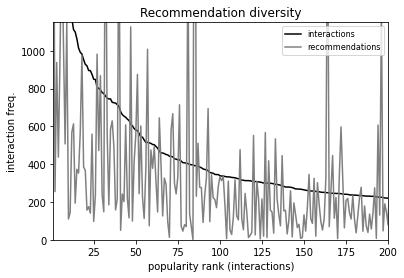

In [40]:
plt.plot(range(1,301),YI, color='k', label = "interactions")
plt.xlim(1,200)
plt.ylim(0,1150)
plt.plot(range(1,301),YR, color='grey', label = "recommendations")
plt.xlabel("popularity rank (interactions)")
plt.ylabel("interaction freq.")
plt.legend(loc="best",  prop={'size': 8})
plt.title("Recommendation diversity")
plt.show()

In [41]:
YR = [x[0] for x in sortPopularR[:300]]
Ys = [x[1] for x in sortPopularR[:300]]
YI = [countsPerItemI[x] for x in Ys]

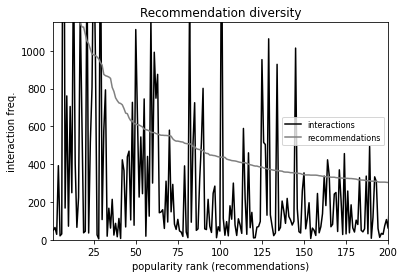

In [42]:
plt.plot(range(1,301),YI, color='k', label = "interactions")
plt.xlim(1,200)
plt.ylim(0,1150)
plt.plot(range(1,301),YR, color='grey', label = "recommendations")
plt.xlabel("popularity rank (recommendations)")
plt.ylabel("interaction freq.")
plt.legend(loc="best",  prop={'size': 8})
plt.title("Recommendation diversity")
plt.show()

# Gini goefficient

The two implementations below compute the gini coefficient either by comparing all pairs, or by doing so for a given number of samples

In [43]:
def gini(z, samples=1000000):
    m = sum(z) / len(z)
    denom = 2 * samples * m
    numer = 0
    for _ in range(samples):
        i = random.choice(z)
        j = random.choice(z)
        numer += math.fabs(i - j)
    return numer / denom

def giniExact(z):
    m = sum(z) / len(z)
    denom = 2 * len(z)**2 * m
    numer = 0
    for i in range(len(z)):
        for j in range(len(z)):
            numer += math.fabs(z[i] - z[j])
    return numer / denom

Compute the gini coefficients of interactions versus distributions for the two distributions computed in the experiments above

In [44]:
gini([x[0] for x in sortPopularI])

0.7192450460801196

In [45]:
gini([x[0] for x in sortPopularR])

0.7701235635166631

### Average cosine similarity between interactions versus recommendations

Given a set of items, measure the average cosine distance between them (by taking a sample of pairs, similar to our implementation of the gini coefficient). This can be used as a rough measure of the diversity of a set of recommendations.

In [46]:
def avCosine(z, samples = 100):
    av = []
    while len(av) < samples:
        i = random.choice(z)
        j = random.choice(z)
        d = 1 - distance.cosine(i, j)
        if not math.isnan(d) and d > 0:
            av.append(d)
    return sum(av) / len(av)

In [47]:
itemFactors = model.item_factors

Compute the average cosine similarity among interactions from a particular user

In [48]:
avCosine([itemFactors[i] for i in itemsPerUser[0]])

0.5007268412318081

Compute the same quantity across a large sample of recommendations and interactions for several users, as an aggregate measure of recommendation versus interaction diversity

In [49]:
avavI = []
avavR = []

while len(avavI) < 1000:
    u = random.choice(range(len(userIDs)))
    if len(itemsPerUser[u]) < 10:
        continue
    aI = avCosine([itemFactors[i] for i in itemsPerUser[u]])
    A = model.recommend(u, Xui, N = len(itemsPerUser[u]))
    aR = avCosine([itemFactors[i[0]] for i in A])
    avavI.append(aI)
    avavR.append(aR)

A lower average cosine similarity among interactions indicates that they are more diverse compared to recommendations

In [50]:
sum(avavI) / len(avavI)

0.6241852634136454

In [51]:
sum(avavR) / len(avavR)

0.8640437527464895

# Fair recommendation

First, implement a latent factor model. Our basic implementation follows the Tensorflow latent factor model from Chapter 5.

In [52]:
userIDs = {}
itemIDs = {}
itemsPerUser = defaultdict(set)
styles = {}
beerNames = {}
interactions = []

for d in parse(os.path.join(dataDir, "beer.json.gz")):
    if not 'user/gender' in d: continue
    g = d['user/gender'] == 'Male'
    u = d['user/profileName']
    i = d['beer/beerId']
    r = d['review/overall']
    styles[i] = d['beer/style']
    beerNames[i] = d['beer/name']
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    itemsPerUser[u].add(i)
    interactions.append((g,u,i,r))

In [53]:
len(interactions)

637221

Data structures to organize interactions by gender

In [54]:
interactionsPerItemG = defaultdict(list) # Male interactions
interactionsPerItemGneg = defaultdict(list) # Other interactions

In [55]:
for g,u,i,r in interactions:
    if g: interactionsPerItemG[i].append((u,r)) # Male interactions for this item
    else: interactionsPerItemGneg[i].append((u,r))

In [56]:
itemsG = set(interactionsPerItemG.keys()) # Set of items associated with male interactions
itemsGneg = set(interactionsPerItemGneg.keys())
itemsBoth = itemsG.intersection(itemsGneg)

In [57]:
mu = sum([r for _,_,_,r in interactions]) / len(interactions) # For initialization

In [58]:
optimizer = tf.keras.optimizers.Adam(0.1)

Latent factor model. The "absoluteFairness" function is new; others are equivalent to our model from Chapter 5.

In [59]:
class LatentFactorModel(tf.keras.Model):
    def __init__(self, mu, K, lamb, lambFair):
        super(LatentFactorModel, self).__init__()
        self.alpha = tf.Variable(mu)
        self.betaU = tf.Variable(tf.random.normal([len(userIDs)],stddev=0.001))
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.lamb = lamb
        self.lambFair = lambFair

    def predict(self, u, i):
        p = self.alpha + self.betaU[u] + self.betaI[i] +\
            tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    def reg(self):
        return self.lamb * (tf.reduce_sum(self.betaU**2) +\
                            tf.reduce_sum(self.betaI**2) +\
                            tf.reduce_sum(self.gammaU**2) +\
                            tf.reduce_sum(self.gammaI**2))
    
    def predictSample(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_u = tf.nn.embedding_lookup(self.betaU, u)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        pred = self.alpha + beta_u + beta_i +\
               tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return pred
    
    # For a single item. This score should be averaged over several items
    def absoluteUnfairness(self, i):
        G = interactionsPerItemG[i]
        Gneg = interactionsPerItemGneg[i]
        # interactions take the form (u,r)
        rG    = tf.reduce_mean(tf.convert_to_tensor([r for _,r in G]))
        rGneg = tf.reduce_mean(tf.convert_to_tensor([r for _,r in Gneg]))
        pG    = tf.reduce_mean(
            self.predictSample([userIDs[u] for u,_ in G], [itemIDs[i]]*len(G)))
        pGneg = tf.reduce_mean(
            self.predictSample([userIDs[u] for u,_ in Gneg], [itemIDs[i]]*len(Gneg)))
        Uabs = tf.abs(tf.abs(pG - rG) - tf.abs(pGneg - rGneg))
        return self.lambFair * Uabs
    
    def call(self, sampleU, sampleI, sampleR):
        pred = self.predictSample(sampleU, sampleI)
        r = tf.convert_to_tensor(sampleR, dtype=tf.float32)
        return tf.nn.l2_loss(pred - r) / len(sampleR)

In [60]:
modelFair = LatentFactorModel(mu, 10, 0.000001, 0.000001)

2022-03-21 23:52:45.360684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 23:52:45.366501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 23:52:45.366994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 23:52:45.367648: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [61]:
def trainingStep(model, interactions):
    Nsamples = 5000
    Nfair = 50
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleR = [], [], []
        for _ in range(Nsamples):
            _,u,i,r = random.choice(interactions)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleR.append(r)

        loss = model(sampleU,sampleI,sampleR)
        loss += sum([model.absoluteUnfairness(i)
                     for i in random.sample(itemsBoth,Nfair)])/Nfair
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [62]:
for i in range(100):
    obj = trainingStep(modelFair, interactions)
    if (i % 50 == 49): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 50, objective = 0.26203477
iteration 100, objective = 0.27126437


Same model, but not including the fairness terms

In [63]:
modelUnfair = LatentFactorModel(mu, 10, 0.000001, 0.000001)

In [64]:
def trainingStepUnfair(model, interactions):
    Nsamples = 5000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleR = [], [], []
        for _ in range(Nsamples):
            _,u,i,r = random.choice(interactions)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleR.append(r)

        loss = model(sampleU,sampleI,sampleR)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [65]:
for i in range(100):
    obj = trainingStepUnfair(modelUnfair, interactions)
    if (i % 50 == 49): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 50, objective = 0.5714966
iteration 100, objective = 0.42219454


# Maximal marginal relevance (MMR)

Similarity between items (in this case cosine)

In [66]:
def cosine(v,w):
    return float(tf.tensordot(v, w, 1) / (tf.norm(v) * tf.norm(w)))

In [67]:
def sim(itemEmbeddings,i,j):
    gamma_i = itemEmbeddings[i]
    gamma_j = itemEmbeddings[j]
    return cosine(gamma_i, gamma_j)

Find the most similar item among a candidate set

In [68]:
def maxSim(itemEmbeddings,i,seq):
    if len(seq) == 0: return 0
    return max([sim(itemEmbeddings,i,j) for j in seq])

Select a random user to receive recommendations

In [69]:
u = random.choice(list(userIDs.keys()))

In [70]:
itemSet = set(itemIDs.keys())

Define a function to get the next recommendation given an initial list, i.e., the mamimal marginally relevant item. Lambda (lamb) controls the tradeoff between compatibility an diversity.

In [71]:
def getNextRec(model,compatScores,itemEmbeddings,seq,lamb):
    scores = [(lamb * s - (1 - lamb) * maxSim(itemEmbeddings,i,seq), i)
        for (s,i) in compatScores if not i in seq]
    (maxScore,maxItem) = max(scores)
    return maxItem

Before re-ranking, generate a list of compatibility scores, i.e., a ranked list of items for a particular user

In [72]:
candidates = list(itemSet.difference(itemsPerUser[u]))
compatScores = list(zip([float(f)
    for f in modelUnfair.predictSample([userIDs[u]]*len(candidates),
        [itemIDs[i] for i in candidates])], candidates))
itemEmbeddings = dict(zip(candidates,
    tf.nn.embedding_lookup(modelUnfair.gammaI, [itemIDs[i] for i in candidates])))

compatScores.sort(reverse=True)

Generate a list of recommendations for the user by repeatedly calling the retrieving the maximal marginally relevant recommendation. First, just get the most relevant items (lambda=1) without encouraging diversity.

Note that this implementation is not particularly optimized, and takes several seconds to generate a list of recommendations.

In [73]:
recs = []
while len(recs) < 10:
    i = getNextRec(modelUnfair,compatScores[:1000],itemEmbeddings,recs,1.0)
    recs.append(i)
[beerNames[i] for i in recs]

['Ouro Preto',
 '2:01 IRA',
 'Empire Strikes Black Wood-Aged Imperial Stout',
 'Hvid Tuborg (White)',
 'Saison De La Chasse',
 'Fauntleroy Stout',
 'Fresh Chester Pale Ale',
 'Pickla Pils',
 "Hale's Cream Ale",
 'Chocolate Raspberry Stout']

More Recommendations for different relevance/diversity tradeoffs. Note that the tradeoff parameter is quite sensitive to the specific scale of the model parameters.

In [74]:
recs = []
while len(recs) < 10:
    i = getNextRec(model,compatScores[:1000],itemEmbeddings,recs,0.25)
    recs.append(i)
[beerNames[i] for i in recs]

['Ouro Preto',
 'Imperial 375 Pale Ale',
 'Great Lakes Owens Olympic Pilsener',
 'Dirty Horse',
 'Hvid Tuborg (White)',
 'Fauntleroy Stout',
 'Empire Strikes Black Wood-Aged Imperial Stout',
 'Moo Coo Brew',
 'Robson Street Hefeweizen',
 'StoneWall Ale']

In [75]:
recs = []
while len(recs) < 10:
    i = getNextRec(model,compatScores[:1000],itemEmbeddings,recs,0.1)
    recs.append(i)
[beerNames[i] for i in recs]

['Ouro Preto',
 'Imperial 375 Pale Ale',
 'StoneWall Ale',
 'Imperial Red',
 'Gose',
 "O'Ryely IPA",
 'Wee Widdle Wabbit',
 'Hvid Tuborg (White)',
 "Olde Rabbit's Foot Bourbon Barrel-Aged Imperial Stout (2009)",
 'Oso Negro']

# Exercises

### 10.1

First just try out a different similarity function (based on the inner product)

In [76]:
def sim(itemEmbeddings,i,j):
    gamma_i = itemEmbeddings[i]
    gamma_j = itemEmbeddings[j]
    return tf.sigmoid(-tf.tensordot(gamma_i, gamma_j, 1)).numpy()

In [77]:
def maxSim(itemEmbeddings,i,seq):
    if len(seq) == 0: return 0
    return max([sim(itemEmbeddings,i,j) for j in seq])

In [78]:
def getNextRec(model,compatScores,itemEmbeddings,seq,lamb):
    rels = dict([(i,s) for (s,i) in compatScores if not i in seq])
    divs = dict([(i,maxSim(itemEmbeddings,i,seq)) for (s,i) in compatScores if not i in seq])
    scores = [(lamb * rels[i] - (1 - lamb) * divs[i], i) for (s,i) in compatScores if not i in seq]
    (maxScore,maxItem) = max(scores)
    return rels[maxItem],divs[maxItem],maxItem

In [79]:
u = random.choice(list(userIDs.keys()))

In [80]:
candidates = list(itemSet.difference(itemsPerUser[u]))
compatScores = list(zip([float(f)
    for f in modelUnfair.predictSample([userIDs[u]]*len(candidates),
        [itemIDs[i] for i in candidates])], candidates))
itemEmbeddings = dict(zip(candidates,
    tf.nn.embedding_lookup(modelUnfair.gammaI, [itemIDs[i] for i in candidates])))

compatScores.sort(reverse=True)

Experiment with different relevance/diversity tradeoffs

In [81]:
xs = []
ys = []
for lamb in [1.0,0.99,0.9,0.75,0.5,0.25,0.1,0.01,0.001]:
    rels = []
    divs = []
    recs = []
    while len(recs) < 5:
        r,d,i = getNextRec(modelUnfair,compatScores[:1000],itemEmbeddings,recs,lamb)
        rels.append(r)
        divs.append(d)
        recs.append(i)
    xs.append(sum(rels)/len(rels))
    ys.append(sum(divs)/len(divs))

And plot the results

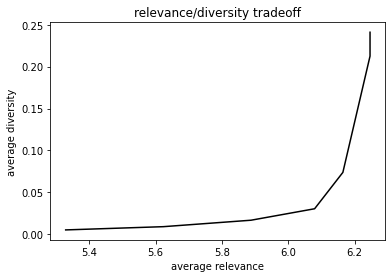

In [82]:
plt.plot(xs,ys,color='k')
plt.xlabel("average relevance")
plt.ylabel("average diversity")
plt.title("relevance/diversity tradeoff")
plt.show()

### 10.2

Concentration effects

In [84]:
data = []
for x in parse(os.path.join(dataDir, "goodreads_reviews_comics_graphic.json.gz")):
    del x['review_text']
    data.append(x)

In [85]:
random.shuffle(data)

In [86]:
userIDs,itemIDs = {},{}
revUIDs,revIIDs = {},{}
for d in data:
    u,i = d['user_id'],d['book_id']
    if not u in userIDs:
        userIDs[u] = len(userIDs)
        revUIDs[userIDs[u]] = u
    if not i in itemIDs:
        itemIDs[i] = len(itemIDs)
        revIIDs[itemIDs[i]] = i

In [87]:
nUsers,nItems = len(userIDs),len(itemIDs)
nUsers,nItems

(59347, 89311)

In [88]:
Xiu = scipy.sparse.lil_matrix((nItems, nUsers))
for d in data:
    Xiu[itemIDs[d['book_id']],userIDs[d['user_id']]] = 1
    
Xui = scipy.sparse.csr_matrix(Xiu.T)

In [90]:
model = bpr.BayesianPersonalizedRanking(factors = 5, use_gpu = False)
model.fit(Xiu)

100%|██████████| 100/100 [00:02<00:00, 33.94it/s, train_auc=88.57%, skipped=2.38%]


Measure concentration in terms of the Gini coefficient

In [91]:
interactionTuples = []
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)

for d in data:
    u,i = d['user_id'],d['book_id']
    interactionTuples.append((userIDs[u],itemIDs[i]))
    itemsPerUser[userIDs[u]].append(itemIDs[i])
    usersPerItem[itemIDs[i]].append(userIDs[u])

In [92]:
recommendationTuples1 = []
for u in range(len(userIDs)):
    A = model.recommend(u, Xui, N = len(itemsPerUser[u]))
    for i, sc in A:
        recommendationTuples1.append((u,i))    

In [93]:
countsPerItemI = defaultdict(int)
countsPerItemR1 = defaultdict(int)

for u,i in interactionTuples:
    countsPerItemI[i] += 1

for u,i in recommendationTuples1:
    countsPerItemR1[i] += 1

Aplly a small penalty for items that are highly recommended (resulting a reduction of concentration). This is essentially just a simple re-ranking strategy.

In [94]:
recommendationTuples2 = []
for u in range(len(userIDs)):
    N = len(itemsPerUser[u])
    A = model.recommend(u, Xui, max(N,100))
    Aadj = []
    for i, sc in A:
        Aadj.append((sc - 0.1*countsPerItemR1[i], i)) # Rerank by penalizing highly-recommended items
    Aadj.sort(reverse=True)
    for sc, i in Aadj[:N]:
        recommendationTuples2.append((u,i))

In [95]:
countsPerItemR2 = defaultdict(int)

for u,i in recommendationTuples2:
    countsPerItemR2[i] += 1

Compare interaction data, recommendations, and "corrected" recommendations in terms of concentration

In [96]:
sortPopularI = [(countsPerItemI[i], i) for i in countsPerItemI]
sortPopularR1 = [(countsPerItemR1[i], i) for i in countsPerItemR1]
sortPopularR2 = [(countsPerItemR2[i], i) for i in countsPerItemR2]

In [97]:
sortPopularI.sort(reverse=True)
sortPopularR1.sort(reverse=True)
sortPopularR2.sort(reverse=True)

In [98]:
gini([x[0] for x in sortPopularI])

0.7235745063899265

In [99]:
gini([x[0] for x in sortPopularR1])

0.7895835507746092

In [100]:
gini([x[0] for x in sortPopularR2])

0.6935412260085039

Ultimately we got a model with lower concentration than the original data. Could adjust the penalty term to control the concentration amount.

### 10.3

Measure parity in terms of beer ABV (alcohol level). Do high- (or low-) alcohol items tend to get recommended more than we would expect from interaction data?

In [102]:
userIDs = {}
itemIDs = {}
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
styles = {}
beerNames = {}
interactions = []

atr = dict()

for d in parse(os.path.join(dataDir, "beer.json.gz")):
    if not 'user/gender' in d: continue
    try:
        a = d['beer/ABV'] > 7.5
    except Exception as e:
        continue
    u = d['user/profileName']
    i = d['beer/beerId']
    r = d['review/overall']
    styles[i] = d['beer/style']
    beerNames[i] = d['beer/name']
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    itemsPerUser[userIDs[u]].append(i)
    usersPerItem[itemIDs[i]].append(u)
    interactions.append((u,i,r))
    atr[itemIDs[i]] = a

In [103]:
nUsers,nItems = len(userIDs),len(itemIDs)
nUsers,nItems

(8402, 34866)

Start by training a BPR model (using the implicit library)

In [104]:
Xiu = scipy.sparse.lil_matrix((nItems, nUsers))
for (u,i,r) in interactions:
    Xiu[itemIDs[i],userIDs[u]] = 1
    
Xui = scipy.sparse.csr_matrix(Xiu.T)

In [105]:
model = bpr.BayesianPersonalizedRanking(factors = 5, use_gpu = False)
model.fit(Xiu)

100%|██████████| 100/100 [00:03<00:00, 29.97it/s, train_auc=81.78%, skipped=17.76%]


Frequency of positive (high alcohol) versus negative (low alcohol) among interactions

In [106]:
apos,aneg = 0,0

for (u,i,r) in interactions:
    if atr[itemIDs[i]]:
        apos += 1
    else:
        aneg += 1

apos,aneg

(216825, 395700)

Frequency among recommendations (low alcohol items end up being slightly over-recommended)

In [107]:
apos,aneg = 0,0

for u in range(len(userIDs)):
    A = model.recommend(u, Xui, N = len(itemsPerUser[u]))
    for i, sc in A:
        if atr[i]:
            apos += 1
        else:
            aneg += 1
            
apos,aneg

(203880, 408645)

As in 10.2, correct using a re-ranking strategy with a simple penalty term (in this case encouraging high-alcohol items to be recommended). Again this could be adjusted to achieve the desired calibration.

In [108]:
apos,aneg = 0,0

for u in range(len(userIDs)):
    N = len(itemsPerUser[u])
    A = model.recommend(u, Xui, N*2)
    Aadj = []
    for i, sc in A:
        Aadj.append((sc + 0.1*atr[i], i))
    Aadj.sort(reverse=True)
    for sc, i in Aadj[:N]:
        if atr[i]:
            apos += 1
        else:
            aneg += 1
    
apos,aneg

(240068, 372457)